<center><img src="logo_skmob.png" width=450 align="left" /></center>

# Measures

- Repo: [http://bit.ly/skmob_repo](http://bit.ly/skmob_repo)
- Docs: [http://bit.ly/skmob_doc](http://bit.ly/skmob_doc)
- Paper: [http://bit.ly/skmob_paper](http://bit.ly/skmob_paper)

We can compute on a `TrajDataFrame` two types of measures:

- **individual measures**, describing features related to the mobility patterns of a single individual
- **collective measures**, describing the mobility patterns of an entire population of individuals

In [1]:
# let's import some useful libraries
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from stats_utils import *
from tqdm import tqdm
import folium
from folium.plugins import HeatMap

In [2]:
# let's import skmob's data structures
import skmob
from skmob import TrajDataFrame, FlowDataFrame

## Loading the data
- We load data of *checkins* made by users on **Brightkite**
- Brightkite is a location-based social network (LBSN)
- The dataset is freely available at the SNAP website: https://snap.stanford.edu/data/loc-brightkite.html

In [3]:
# download the dataset using pandas
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=500000, 
                 names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])

# convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
            longitude='longitude', datetime='check-in_time', user_id='user')
tdf.head(3)

,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683


In [11]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 1231
number of records:	 500000


# Individual measures

- computed on the trajectories of a <u>single individual</u>
- quantify standard *mobility patterns*
- examples: 
    - radius of gyration
    - jump lengths
    - max distance
    - individual mobility network

## Radius of gyration $r_g$
characteristic distance traveled by an individual:

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

$r_{cm}$ is the position vector of the *center of mass* of the set of locations visited by the individual

In [12]:
from skmob.measures.individual import radius_of_gyration

In [13]:
rg_df = radius_of_gyration(tdf)
rg_df.head()

100%|██████████| 1231/1231 [00:03<00:00, 336.61it/s]


,uid,radius_of_gyration
0,0,1564.436792
1,1,2467.773523
2,2,1439.649774
3,3,1752.604191
4,4,5380.503250


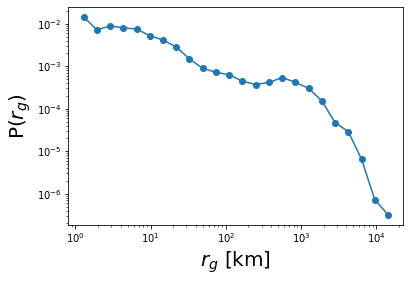

In [15]:
# let's plot the distribution of the radius of gyration
fig = plt.figure()
x, y = zip(*lbpdf(1.5, list(rg_df.radius_of_gyration[rg_df.radius_of_gyration >= 1.0])))
plt.plot(x, y, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=20);plt.ylabel('P($r_g$)', fontsize=20)
plt.loglog();plt.show()

## Jump lengths
- a jump length is is the distance between two consecutive visits of an individual
- given a `TrajDataFrame`, skmob computes the lengths for each individual independently
- use the `jump_lengths` function

In [16]:
from skmob.measures.individual import jump_lengths

In [20]:
jl_df = jump_lengths(tdf) # disable progress bar with show_progress=False
jl_df.head(4)

100%|██████████| 1231/1231 [00:05<00:00, 232.87it/s]


,uid,jump_lengths
0,0,"[19.640467328877936, 0.0, 0.0, 1.7434311010381..."
1,1,"[6.505330424378251, 46.75436600375988, 53.9284..."
2,2,"[0.0, 0.0, 0.0, 0.0, 3.6410097195943507, 0.0, ..."
3,3,"[3861.2706300798827, 4.061631313492122, 5.9163..."


In [21]:
# merge=True put all distances of the individuals into a single list
jl_list = jump_lengths(tdf, merge=True)
type(jl_list)

100%|██████████| 1231/1231 [00:05<00:00, 238.86it/s]


list

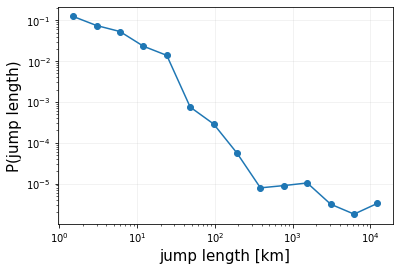

In [22]:
# let's plot the distribution of jump lengths
fig = plt.figure()
x, y = zip(*lbpdf(2.0, [dist for dist in jl_list[:10000] if dist >= 1]))
plt.plot(x, y, marker='o')
plt.grid(alpha=0.2) 
plt.xlabel('jump length [km]', fontsize=15);plt.ylabel('P(jump length)', fontsize=15)
plt.loglog();plt.show()

### Other types of distances

- maximum distance traveled by each individual `maximum_distance`
- sum of distances of an individual `distance_straight_line`
- maximum distance traved by an individual for their home `max_distance_from_home`

In [23]:
from skmob.measures.individual import max_distance_from_home, distance_straight_line, maximum_distance

In [24]:
md_df = maximum_distance(tdf)

100%|██████████| 1231/1231 [00:05<00:00, 227.31it/s]


Text(0.5, 0, 'max')

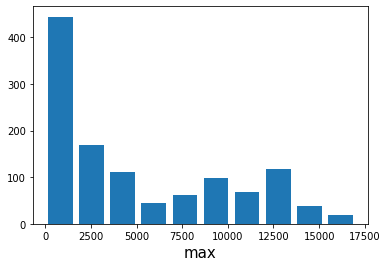

In [26]:
# let's plot the distribution of those three measures
fig, ax1 = plt.subplots(1, 1)
ax1.hist(md_df.maximum_distance, bins=10, rwidth=0.8)
ax1.set_xlabel('max', fontsize=15)


## Individual mobility network
a network where: 
- nodes represent locations visited by the individual
- directed edges represent trips between the locations made by the individual 

In [27]:
from skmob.measures.individual import individual_mobility_network

In [28]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

100%|██████████| 1231/1231 [00:05<00:00, 216.30it/s]


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,0,37.774929,-122.419415,37.600747,-122.382376,1
1,0,37.600747,-122.382376,37.615223,-122.389979,1
2,0,37.600747,-122.382376,37.580304,-122.343679,1
3,0,37.615223,-122.389979,39.878664,-104.682105,1
4,0,37.615223,-122.389979,37.580304,-122.343679,1


In [29]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.head()

,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
1397,2,39.746397,-104.959766,39.750729,-104.917552,1
1398,2,39.746397,-104.959766,39.711161,-104.934527,1
1399,2,39.746397,-104.959766,39.825947,-105.145944,1
1400,2,39.746397,-104.959766,39.739154,-104.984703,1
1401,2,39.746397,-104.959766,39.785470,-104.895895,1


# Collective measures

- are computed on the trajectories of a <u>population of individuals</u>
- quantify standard *mobility patterns*
- examples: 
    - origin destination matrix
    - visits per time unit

## Visits per location

number of visits to a location made by the population of individuals

In [30]:
from skmob.measures.collective import visits_per_location

In [31]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

,lat,lng,n_visits
0,0.000000,0.000000,10378
1,39.739154,-104.984703,9958
2,40.014986,-105.270546,4548
3,37.774929,-122.419415,3615
4,40.714269,-74.005973,2881


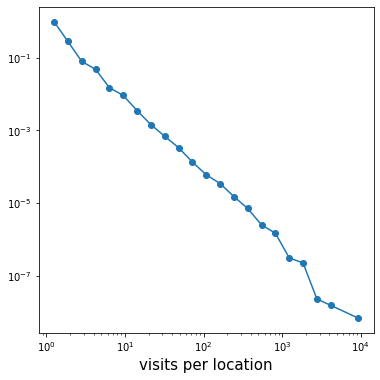

In [32]:
fig = plt.figure(figsize=(6, 6))
x, y = zip(*lbpdf(1.5, list(vpl_df.n_visits)))
plt.plot(x, y, marker='o')
plt.xlabel('visits per location', fontsize=15)
plt.loglog()
plt.show()

## Visits per time unit

number of visits of the population of individuals in a time slot (default: 1 hour)


In [33]:
from skmob.measures.collective import visits_per_time_unit

In [34]:
vtu_df = visits_per_time_unit(tdf)
vtu_df.head()

,n_visits
datetime,
2008-03-22 05:00:00+00:00,2
2008-03-22 06:00:00+00:00,2
2008-03-22 07:00:00+00:00,0
2008-03-22 08:00:00+00:00,0
2008-03-22 09:00:00+00:00,0


/home/lucpappalard/miniconda3/envs/skmob/lib/python3.7/site-packages/pandas-0.24.2-py3.7-linux-x86_64.egg/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


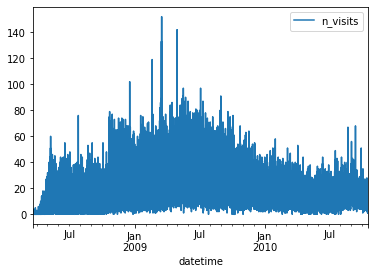

In [36]:
vtu_df.plot()
plt.show()

## Origin destination matrix

a network where: 
- nodes represent locations visited by the population of individuals
- directed edges represent trips between the locations made by the individuals

In [37]:
from skmob.measures.collective import origin_destination_matrix

In [38]:
od_df = origin_destination_matrix(tdf)
od_df.head()

100%|██████████| 1231/1231 [00:02<00:00, 463.06it/s]


,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,37.774929,-122.419415,37.600747,-122.382376,3
1,37.774929,-122.419415,37.630490,-122.411084,8
2,37.774929,-122.419415,37.584103,-122.366083,55
3,37.774929,-122.419415,37.613825,-122.486919,2
4,37.774929,-122.419415,37.654656,-122.407750,12


<center><img src="trackandknow_logo.png" width=450 align="left" /></center>

# Car Crash prediction
conceded by EU project Track&Know H2020 grant #780754

## The data set
- GPS trajectories of private vehicles traveling in Tuscany
- period of observation of 6 months
- we know whether or not a vehicles crashed in a month

<img src="https://kdd.isti.cnr.it/sites/kdd.isti.cnr.it/files/fig1.png" width="600" height="400" />

## Car Crash prediction problem
*Given the GPS trajectories of a vehicle for a month, predict <u>whether or not</u> the vehicle will crash in the next month.*

- create sub-trajectories of length 1 month
- extract mobility features from sub-trajectories
- each vehicle is a row in the data set
- label 1 indicates crash, label 0 no-crash

Some of the features:
- number of trips
- trips in the afternoon/morning/night
- radius of gyration
- quick cornerning, accelerations, speed
- ...

In [4]:
%matplotlib inline
import pickle
from sklearn import tree
import pydotplus
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pydotplus'

In [40]:
filename = 'data/decision_tree_car_crash.pkl'
dt_cc = pickle.load(open(filename, 'rb'))

filename = 'data/attributes.pkl'
attributes = pickle.load(open(filename, 'rb'))

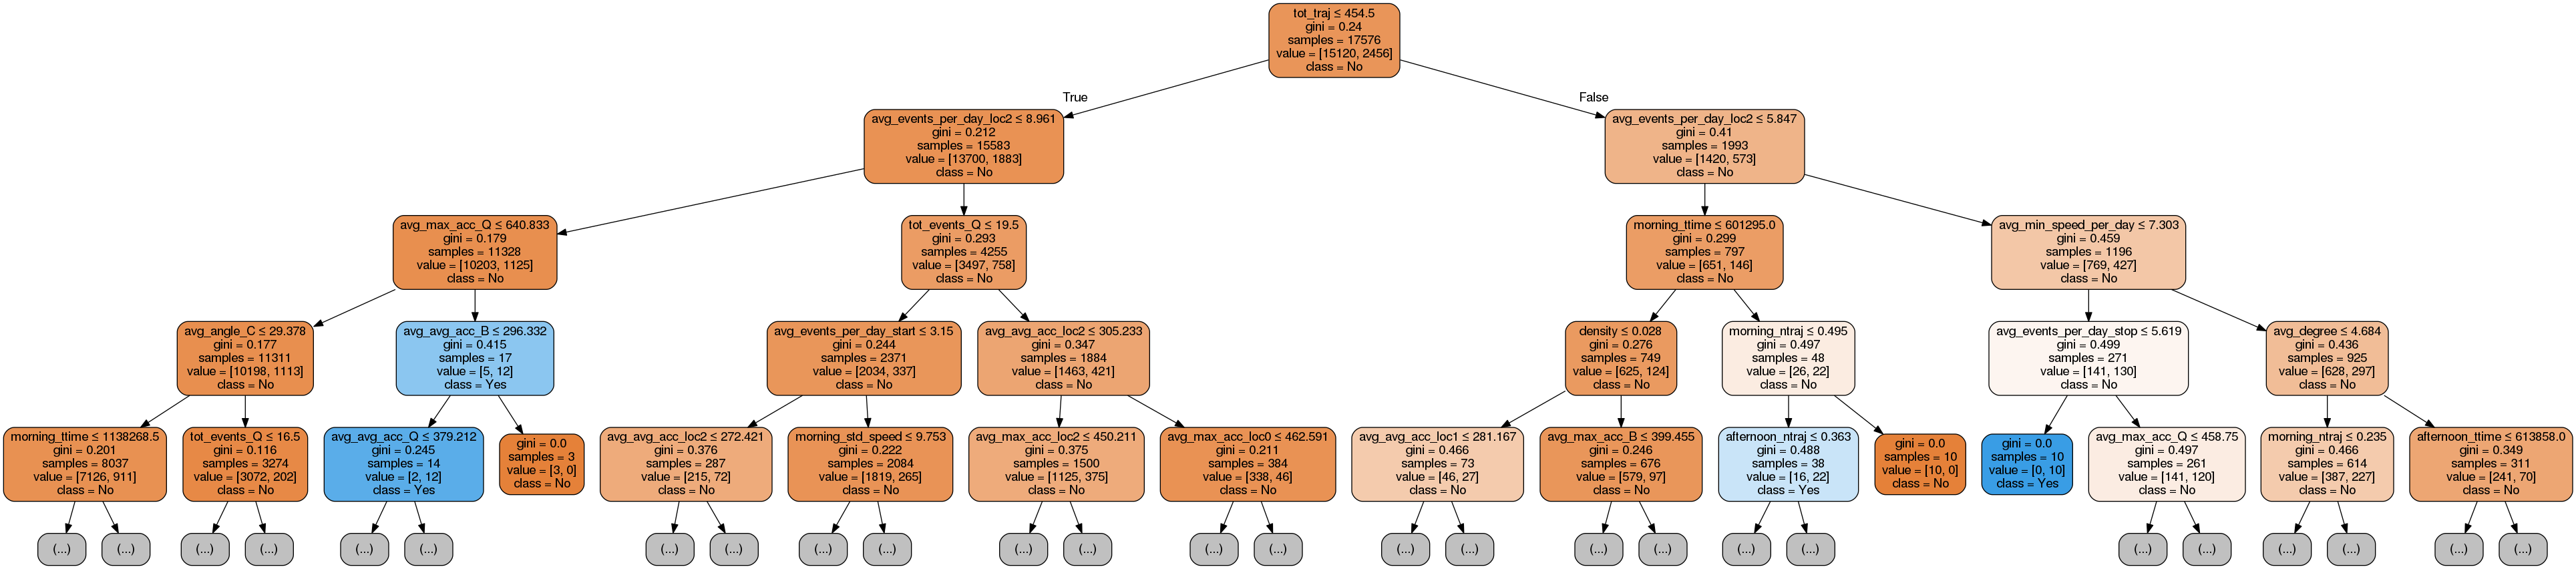

In [42]:
dot_data = tree.export_graphviz(dt_cc, out_file=None,  max_depth=4,
                feature_names=attributes, 
                class_names=['Yes' if x == 1 else 'No' for x in dt_cc.classes_],  
                filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

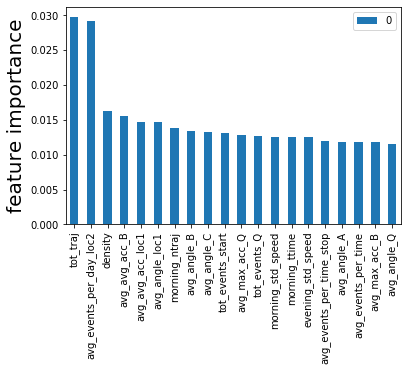

In [6]:
d = {}
for importance, name in sorted(zip(dt_cc.feature_importances_, attributes),reverse=True)[:20]:
    d[name] = importance
df_importance = pd.DataFrame.from_dict(d, orient='index')
df_importance.plot(kind='bar', rot=90)
plt.ylabel('feature importance', fontsize=20)
plt.show()